## 1. Imports

In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go # talvez eu tire
import yfinance as yf
import math
import tensorflow as tf

from datetime import datetime

from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Conv1D
from keras.layers import Bidirectional, TimeDistributed, MaxPooling1D, Flatten
from keras.metrics import Accuracy, RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from keras.models import Sequential
from keras.regularizers import L1, L2
from keras.utils import plot_model

from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from pandas.plotting import autocorrelation_plot
from plotly.subplots import make_subplots

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score, mean_squared_error, max_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [5]:
sns.set_style('whitegrid')
yf.pdr_override()

## 2. Getting the Data

In [17]:
data = pdr.get_data_yahoo('VALE3.SA', start='2000-01-02', end='2023-01-02')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03 00:00:00-02:00,3.500000,3.542500,3.500000,3.500000,1.665135,585600
2000-01-04 00:00:00-02:00,3.466666,3.474166,3.416666,3.416666,1.625488,782400
2000-01-05 00:00:00-02:00,3.375000,3.416666,3.375000,3.416666,1.625488,1876800
2000-01-06 00:00:00-02:00,3.416666,3.500000,3.416666,3.416666,1.625488,792000
2000-01-07 00:00:00-02:00,3.458333,3.559166,3.458333,3.541666,1.684957,5347200


In [18]:
data = data.rename(columns={'Open':'Abertura', 'High':'Máximo', 'Low':'Mínimo', 
                   'Close':'Fechamento', 'Adj Close':'Fechamento ajust'})
data.head()

,Abertura,Máximo,Mínimo,Fechamento,Fechamento ajust,Volume
Date,,,,,,
2000-01-03 00:00:00-02:00,3.500000,3.542500,3.500000,3.500000,1.665135,585600
2000-01-04 00:00:00-02:00,3.466666,3.474166,3.416666,3.416666,1.625488,782400
2000-01-05 00:00:00-02:00,3.375000,3.416666,3.375000,3.416666,1.625488,1876800
2000-01-06 00:00:00-02:00,3.416666,3.500000,3.416666,3.416666,1.625488,792000
2000-01-07 00:00:00-02:00,3.458333,3.559166,3.458333,3.541666,1.684957,5347200


### 2.1 Descriptive Statistics and Info about the Data

In [19]:
data.describe()

,Abertura,Máximo,Mínimo,Fechamento,Fechamento ajust,Volume
count,5778.000000,5778.000000,5778.000000,5778.000000,5778.000000,5.778000e+03
mean,35.314789,35.807189,34.786859,35.292760,22.462873,1.075441e+07
std,23.992295,24.274112,23.659938,23.965467,20.111365,1.893271e+07
min,2.875000,2.921666,2.750000,2.833333,1.347966,0.000000e+00
25%,16.781876,17.059999,16.413750,16.712501,9.049412,2.715350e+06
50%,32.830000,33.365000,32.372499,32.807499,18.703366,4.823900e+06
75%,49.419998,50.012501,48.817500,49.490002,27.759335,1.242375e+07
max,119.800003,120.449997,115.250000,118.720001,94.871948,3.492435e+08


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5778 entries, 2000-01-03 00:00:00-02:00 to 2022-12-29 00:00:00-03:00
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Abertura          5778 non-null   float64
 1   Máximo            5778 non-null   float64
 2   Mínimo            5778 non-null   float64
 3   Fechamento        5778 non-null   float64
 4   Fechamento ajust  5778 non-null   float64
 5   Volume            5778 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 316.0 KB


### 2.2 Data visualization

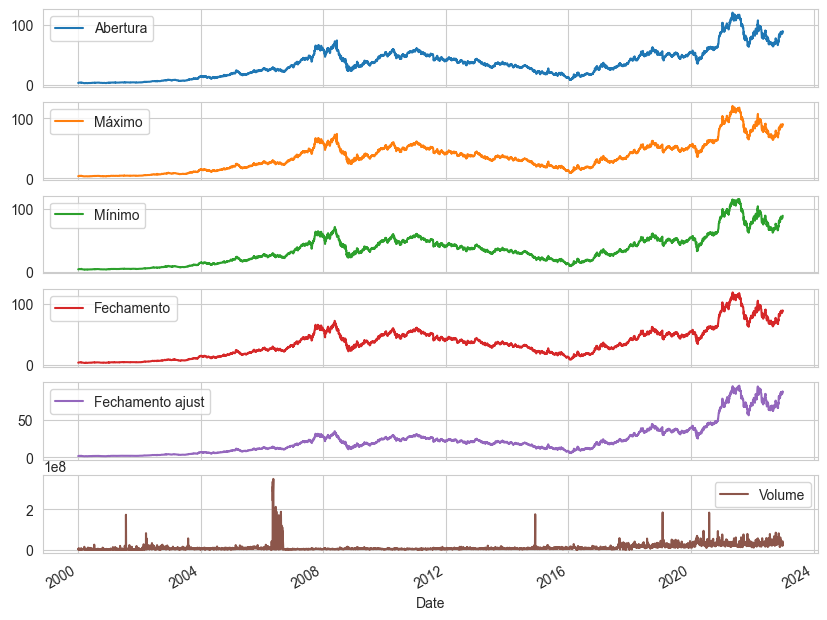

In [21]:
data.plot(legend=True,subplots=True, figsize = (10, 8))
plt.show()

In [29]:
data = data.reset_index(drop=True)
data.head()

,Date,Abertura,Máximo,Mínimo,Fechamento,Fechamento ajust,Volume
0,2000-01-03,3.500000,3.542500,3.500000,3.500000,1.665135,585600
1,2000-01-04,3.466666,3.474166,3.416666,3.416666,1.625488,782400
2,2000-01-05,3.375000,3.416666,3.375000,3.416666,1.625488,1876800
3,2000-01-06,3.416666,3.500000,3.416666,3.416666,1.625488,792000
4,2000-01-07,3.458333,3.559166,3.458333,3.541666,1.684957,5347200


#### Moving average (MA) - visualizar média móvel das ações período 200 dias

In [42]:
ma = pd.DataFrame(data[['Date','Fechamento ajust']])
ma['Média móvel'] = ma['Fechamento ajust'].rolling(window=200).mean()
ma

,Date,Fechamento ajust,Média móvel
0,2000-01-03,1.665135,NaN
1,2000-01-04,1.625488,NaN
2,2000-01-05,1.625488,NaN
3,2000-01-06,1.625488,NaN
4,2000-01-07,1.684957,NaN
...,...,...,...
5773,2022-12-23,84.465065,74.470905
5774,2022-12-26,85.238083,74.446043
5775,2022-12-27,87.273392,74.433721
5776,2022-12-28,87.077682,74.444481


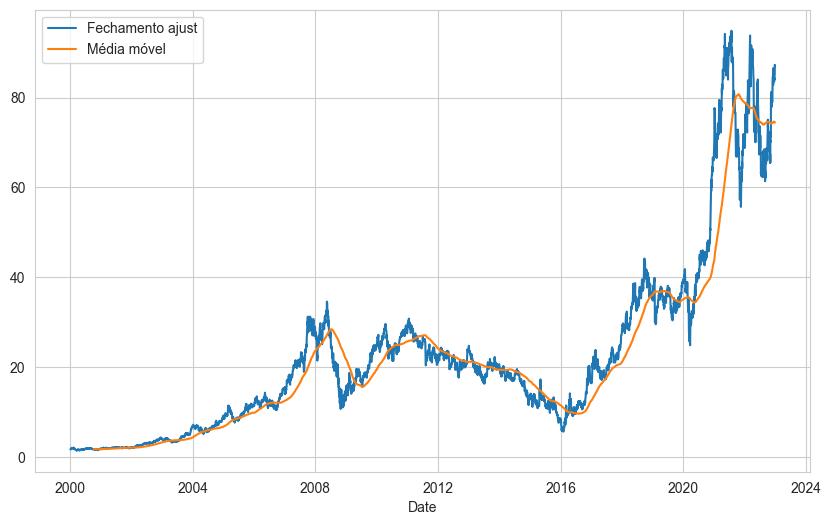

In [43]:
ma.plot(x='Date', y=['Fechamento ajust', 'Média móvel'], figsize=(10, 6))
plt.show()

#### Average daily stock return

In [44]:
d_return = pd.DataFrame(data[['Date','Fechamento ajust']])
d_return['Retorno diário'] = d_return['Fechamento ajust'].pct_change()
d_return.head()

,Date,Fechamento ajust,Retorno diário
0,2000-01-03,1.665135,NaN
1,2000-01-04,1.625488,-0.023810
2,2000-01-05,1.625488,0.000000
3,2000-01-06,1.625488,0.000000
4,2000-01-07,1.684957,0.036585


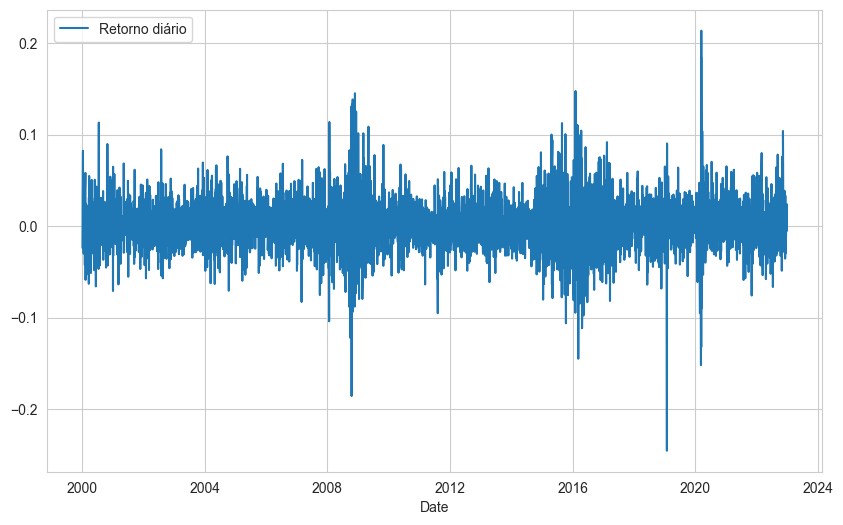

In [50]:
d_return.plot(x='Date', y=['Retorno diário'], figsize=(10, 6))
plt.show()

## 3. Data manipulation and transformation

### 3.1 Spliting Data as Train and Validation

In [57]:
data_length = len(data)  # quantidade de linhas
train_length = round(data_length * 0.7) # 70% treino + 30% validação
validation_length = data_length - train_length
print('Quantidade de linhas Data: ', data_length)
print('Quantidade de linhas Train data: ', train_length)
print('Quantidade de linhas Validation data: ', validation_length)

Quantidade de linhas Data:  5778
Quantidade de linhas Train data:  4045
Quantidade de linhas Validation data:  1733


In [63]:
data_train = data[:train_length].iloc[:, :2]
# convertendo Date para um objeto datatime
data_train['Date'] = pd.to_datetime(data_train['Date']) 
data_train

,Date,Abertura
0,2000-01-03,3.500000
1,2000-01-04,3.466666
2,2000-01-05,3.375000
3,2000-01-06,3.416666
4,2000-01-07,3.458333
...,...,...
4040,2016-01-08,11.070000
4041,2016-01-11,10.500000
4042,2016-01-12,10.460000
4043,2016-01-13,9.610000


In [62]:
data_validation = data[train_length:].iloc[:, :2]
data_validation['Date'] = pd.to_datetime(data_validation['Date'])
data_validation

,Date,Abertura
4045,2016-01-15,9.170000
4046,2016-01-18,9.310000
4047,2016-01-19,9.510000
4048,2016-01-20,8.970000
4049,2016-01-21,9.210000
...,...,...
5773,2022-12-23,85.279999
5774,2022-12-26,86.419998
5775,2022-12-27,88.000000
5776,2022-12-28,89.190002


### 3.2 Creating Train Dataset from Train split

In [65]:
dataset_train = data_train.Abertura.values
dataset_train.shape

(4045,)

In [66]:
# trocando a forma de (4045,) para (4045,1)
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(4045, 1)

### 3.3 Normalization / Feature Scaling

In [68]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train_scaled = scaler.fit_transform(dataset_train)
dataset_train_scaled.shape

(4045, 1)

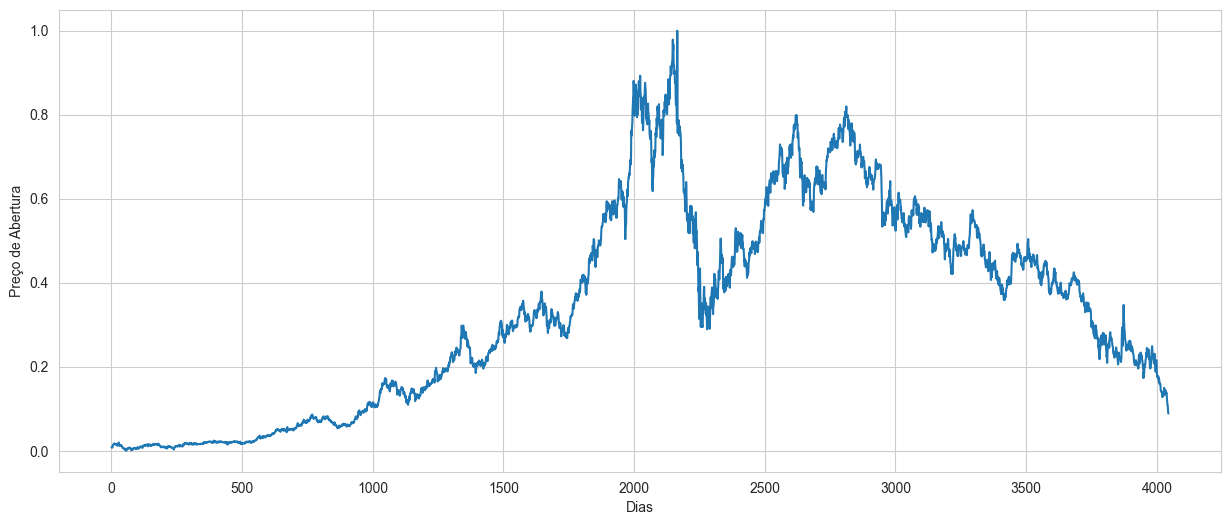

In [73]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel('Dias')
plt.ylabel('Preço de Abertura')
plt.show()

### 3.4 Creating X_train and y_train from Train data

In [76]:
x_train = [] # input data
y_train = [] # target data

for i in range(50, train_length):
    x_train.append(dataset_train_scaled[i-50:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# Convert the x_train and y_train list to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
# out << shape of x_train: (1134, 50) / shape of y_train: (1134,)

#Reshape
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
x_train.shape, y_train.shape

((3995, 50, 1), (3995, 1))

## 4. Creating RNN Model

In [85]:
# initializing the RNN
model_rnn = Sequential()

# adding RNN layers and dropout regulatization
model_rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (x_train.shape[1],1)))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units = 50))
model_rnn.add(Dropout(0.2))

# final layers
model_rnn.add(Dense(units = 1)) # adding the output layer
model_rnn.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae', 'accuracy', tf.keras.metrics.RootMeanSquaredError(), 'mape']) # compiling RNN

# fitting the RNN
history = model_rnn.fit(x_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
125/125 [==============================] - 6s 24ms/step - loss: 0.1909 - mse: 0.1909 - mae: 0.3391 - accuracy: 2.5031e-04 - root_mean_squared_error: 0.4369 - mape: 8885.4600
Epoch 2/50
125/125 [==============================] - 3s 24ms/step - loss: 0.0670 - mse: 0.0670 - mae: 0.2034 - accuracy: 5.0063e-04 - root_mean_squared_error: 0.2589 - mape: 3743.1106
Epoch 3/50
125/125 [==============================] - 3s 26ms/step - loss: 0.0353 - mse: 0.0353 - mae: 0.1460 - accuracy: 5.0063e-04 - root_mean_squared_error: 0.1880 - mape: 43529.2188
Epoch 4/50
125/125 [==============================] - 3s 25ms/step - loss: 0.0231 - mse: 0.0231 - mae: 0.1162 - accuracy: 5.0063e-04 - root_mean_squared_error: 0.1520 - mape: 9662.0762
Epoch 5/50
125/125 [==============================] - 3s 26ms/step - loss: 0.0170 - mse: 0.0170 - mae: 0.0987 - accuracy: 5.0063e-04 - root_mean_squared_error: 0.1305 - mape: 563.8875
Epoch 6/50
125/125 [==============================] - 4s 29ms/step - loss: 

125/125 [==============================] - 4s 31ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0237 - accuracy: 5.0063e-04 - root_mean_squared_error: 0.0321 - mape: 1289.0220
Epoch 46/50
125/125 [==============================] - 4s 31ms/step - loss: 9.6369e-04 - mse: 9.6369e-04 - mae: 0.0228 - accuracy: 5.0063e-04 - root_mean_squared_error: 0.0310 - mape: 1435.1613
Epoch 47/50
125/125 [==============================] - 4s 31ms/step - loss: 9.7886e-04 - mse: 9.7886e-04 - mae: 0.0230 - accuracy: 5.0063e-04 - root_mean_squared_error: 0.0313 - mape: 9783.4717
Epoch 48/50
125/125 [==============================] - 4s 31ms/step - loss: 9.2280e-04 - mse: 9.2280e-04 - mae: 0.0224 - accuracy: 5.0063e-04 - root_mean_squared_error: 0.0304 - mape: 768.2109
Epoch 49/50
125/125 [==============================] - 4s 31ms/step - loss: 9.4640e-04 - mse: 9.4640e-04 - mae: 0.0227 - accuracy: 5.0063e-04 - root_mean_squared_error: 0.0308 - mape: 1195.1094
Epoch 50/50
125/125 [==============================

In [88]:
history.history

{'loss': [0.1908726841211319,
  0.06701432168483734,
  0.0353301465511322,
  0.023102033883333206,
  0.017037492245435715,
  0.013136079534888268,
  0.009650655090808868,
  0.008197149261832237,
  0.006954021751880646,
  0.006122790277004242,
  0.005379341077059507,
  0.004700175486505032,
  0.003833232680335641,
  0.0036155018024146557,
  0.003292680950835347,
  0.002921773586422205,
  0.002850254299119115,
  0.0026977784000337124,
  0.0022548609413206577,
  0.0021961149759590626,
  0.0020052618347108364,
  0.002030791714787483,
  0.0016989429714158177,
  0.0016719757113605738,
  0.001681614201515913,
  0.0016830936074256897,
  0.001633694744668901,
  0.001373007777146995,
  0.0013854305725544691,
  0.0013604629784822464,
  0.001259960699826479,
  0.00121630250941962,
  0.0012449983041733503,
  0.0012353399069979787,
  0.0011139636626467109,
  0.0012181589845567942,
  0.0011514945654198527,
  0.0011565980967134237,
  0.0011075068032369018,
  0.0010720082791522145,
  0.0010384392226114

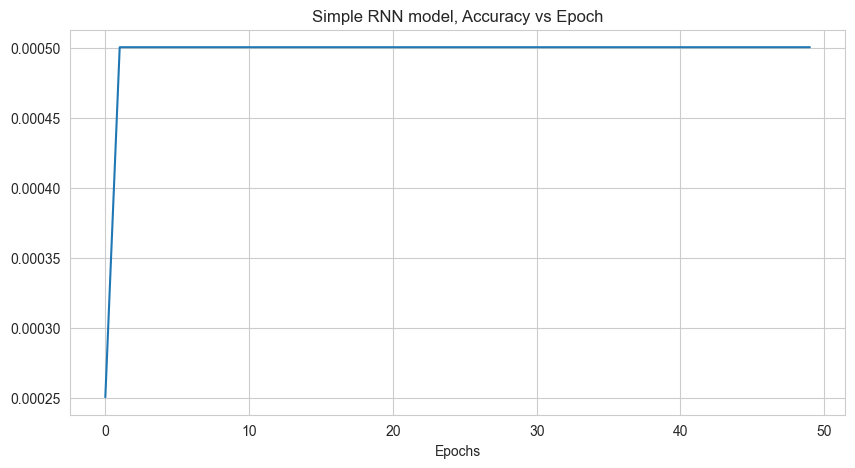

In [92]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

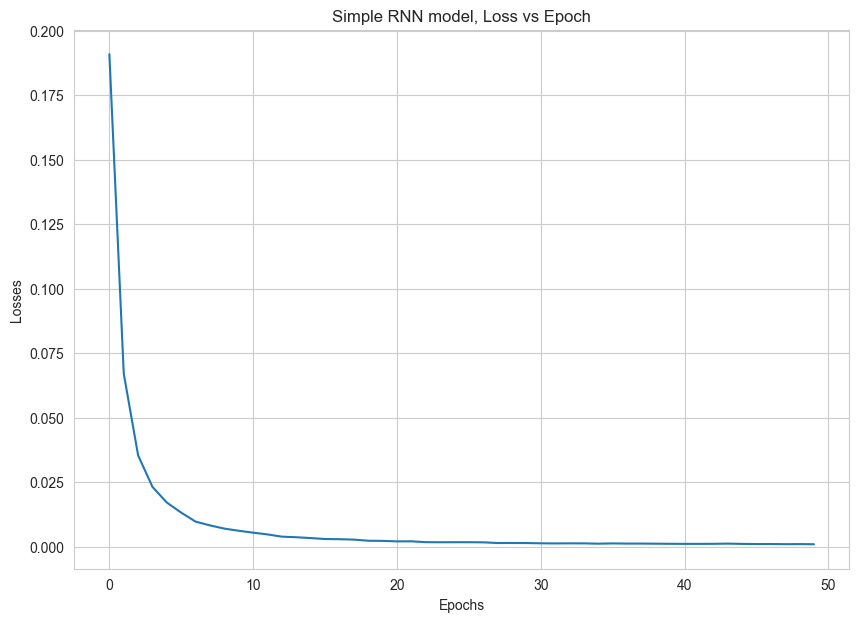

In [93]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

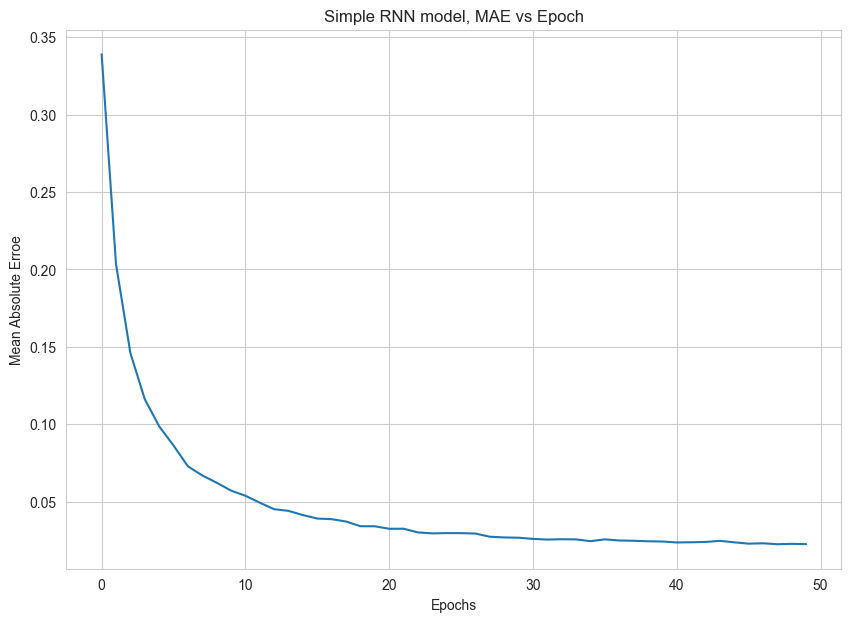

In [94]:
# Plotting MAE vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["mae"])
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Erroe")
plt.title("Simple RNN model, MAE vs Epoch")
plt.show()

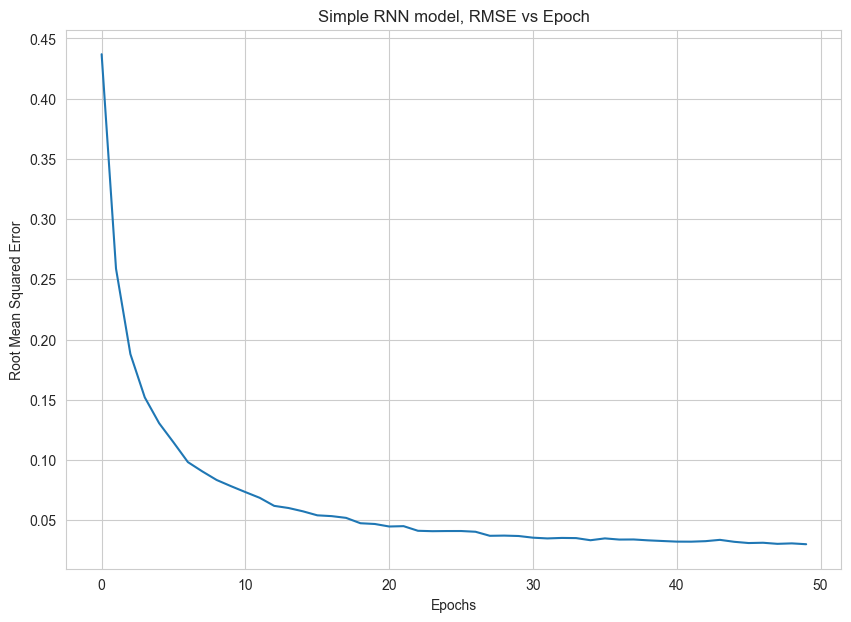

In [95]:
# Plotting RMSE vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["root_mean_squared_error"])
plt.xlabel("Epochs")
plt.ylabel("Root Mean Squared Error")
plt.title("Simple RNN model, RMSE vs Epoch")
plt.show()

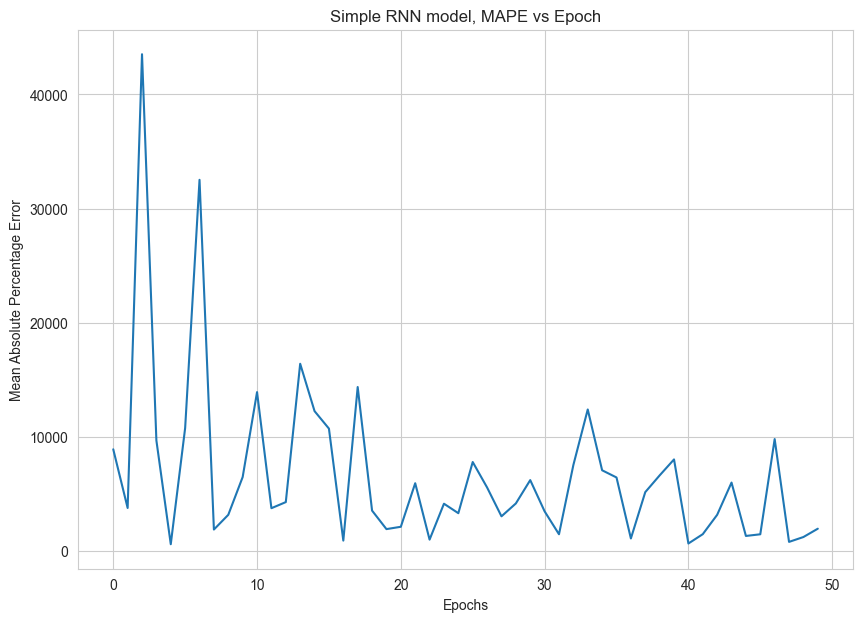

In [96]:
# Plotting MAPE vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["mape"])
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Percentage Error")
plt.title("Simple RNN model, MAPE vs Epoch")
plt.show()

### 4.1 Model predictions for train data

In [97]:
y_pred = model_rnn.predict(x_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original

y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_pred.shape, y_train.shape

125/125 [==============================] - 2s 8ms/step


((3995, 1), (3995, 1))

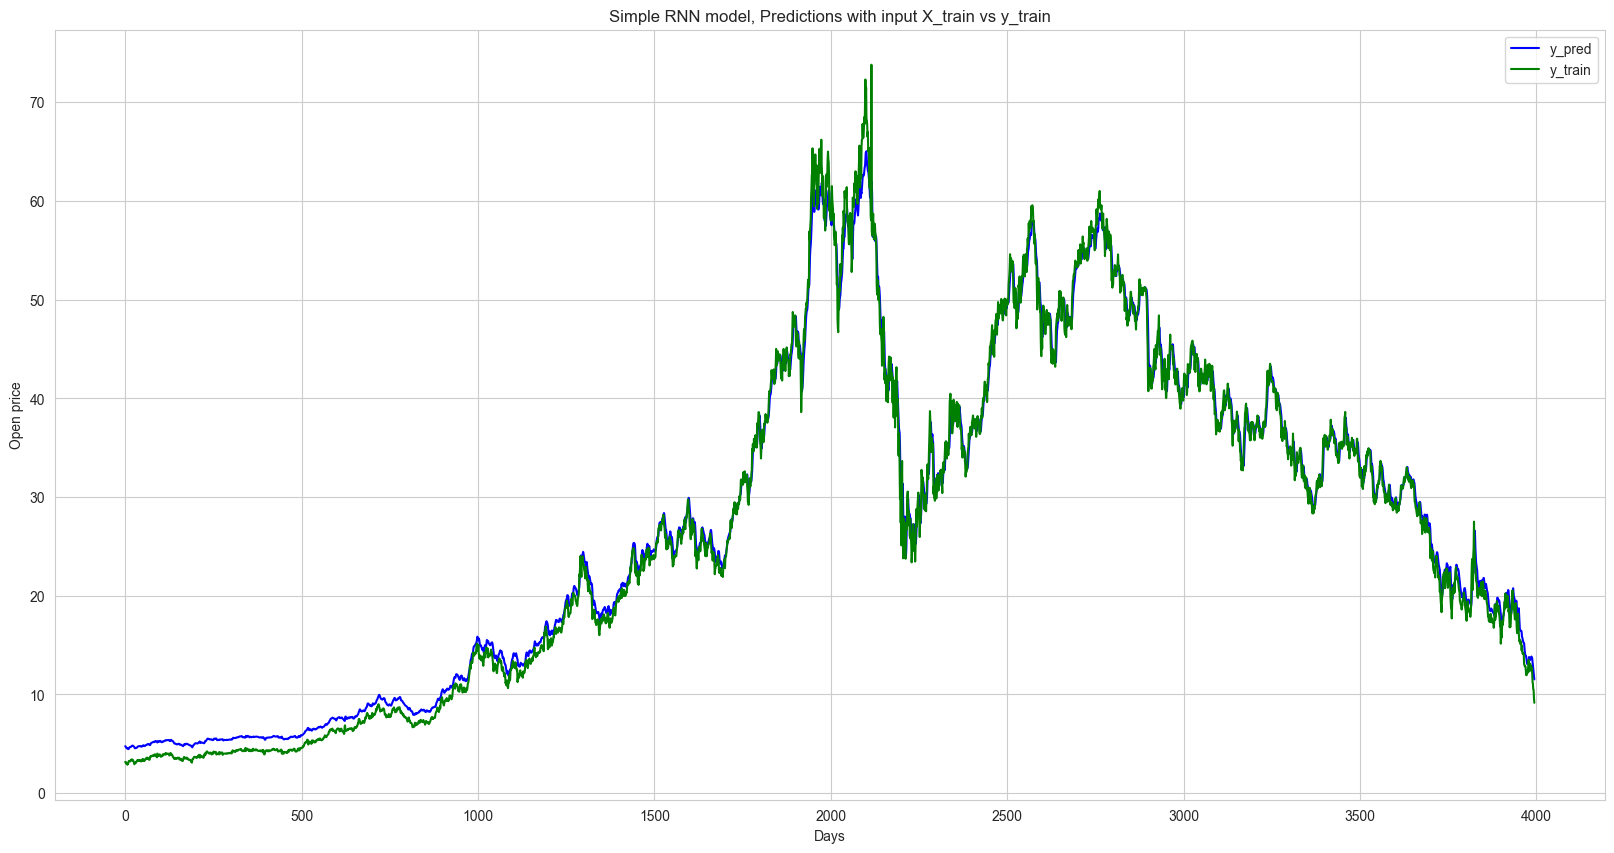

In [100]:
# visualisation
plt.figure(figsize = (20,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [101]:
# Calcular métricas
rmse = np.sqrt(np.mean(((y_pred - y_train) ** 2)))
rmse

1.3151296129627799

### 4.2 Creating Test Dataset from Validation Data

In [102]:
dataset_validation = data_validation.Abertura.values  # getting "Abertura" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (1733, 1)


In [103]:
# Creating x_test and y_test
x_test = []
y_test = []

for i in range(50, validation_length):
    x_test.append(scaled_dataset_validation[i-50:i,0])
    y_test.append(scaled_dataset_validation[i,0])
    
# Converting to array
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [104]:
y_pred_of_test = model_rnn.predict(x_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 

53/53 [==============================] - 0s 8ms/step


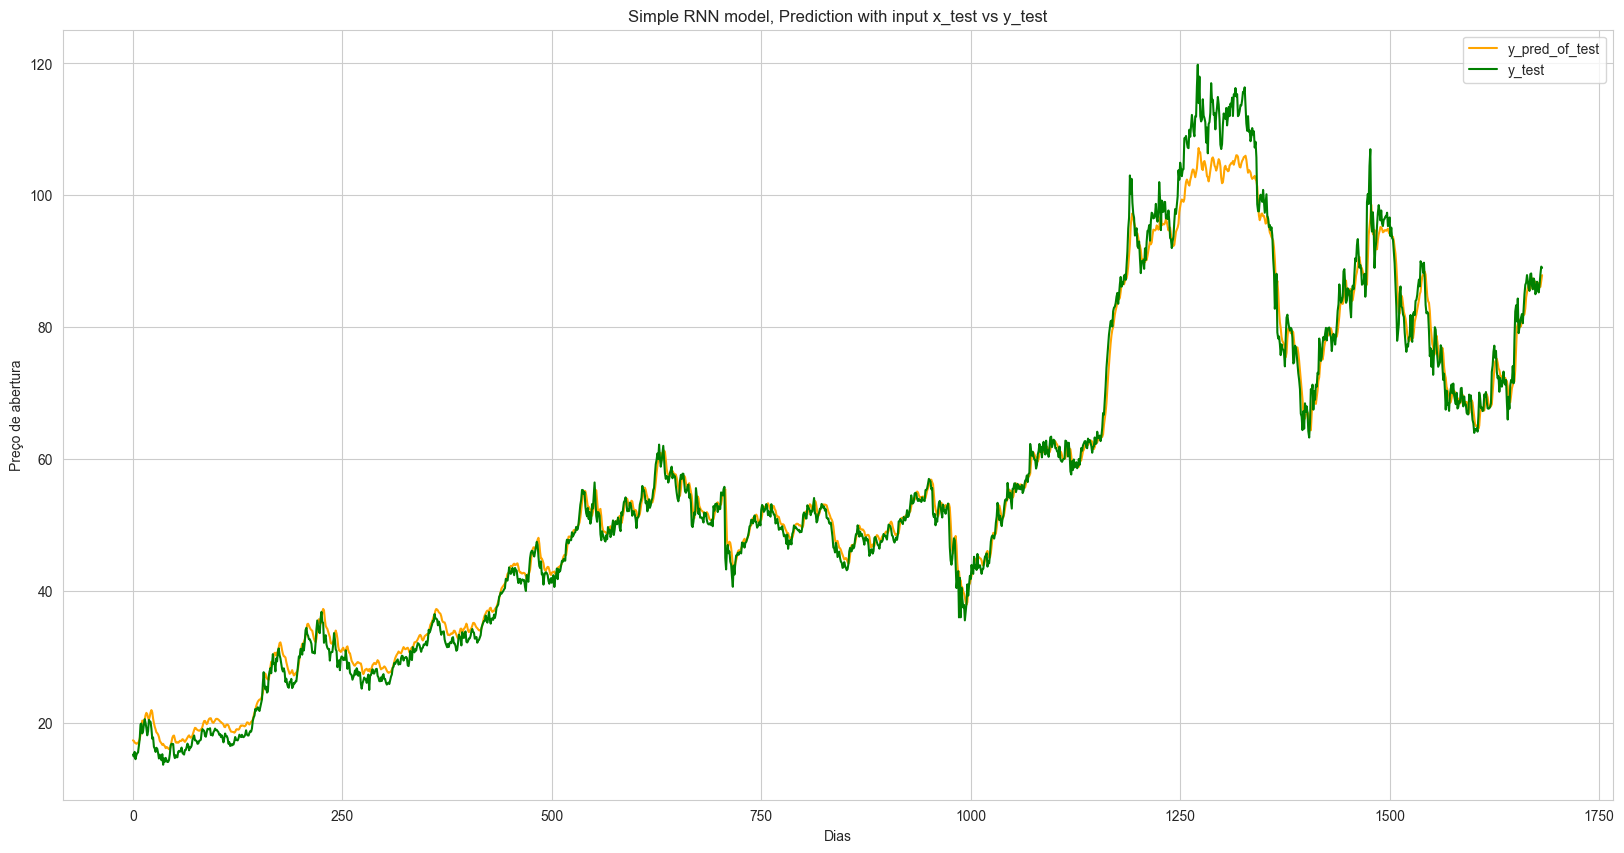

In [105]:
# visualisation
plt.figure(figsize = (20,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Dias")
plt.ylabel("Preço de abertura")
plt.title("Simple RNN model, Prediction with input x_test vs y_test")
plt.legend()
plt.show()

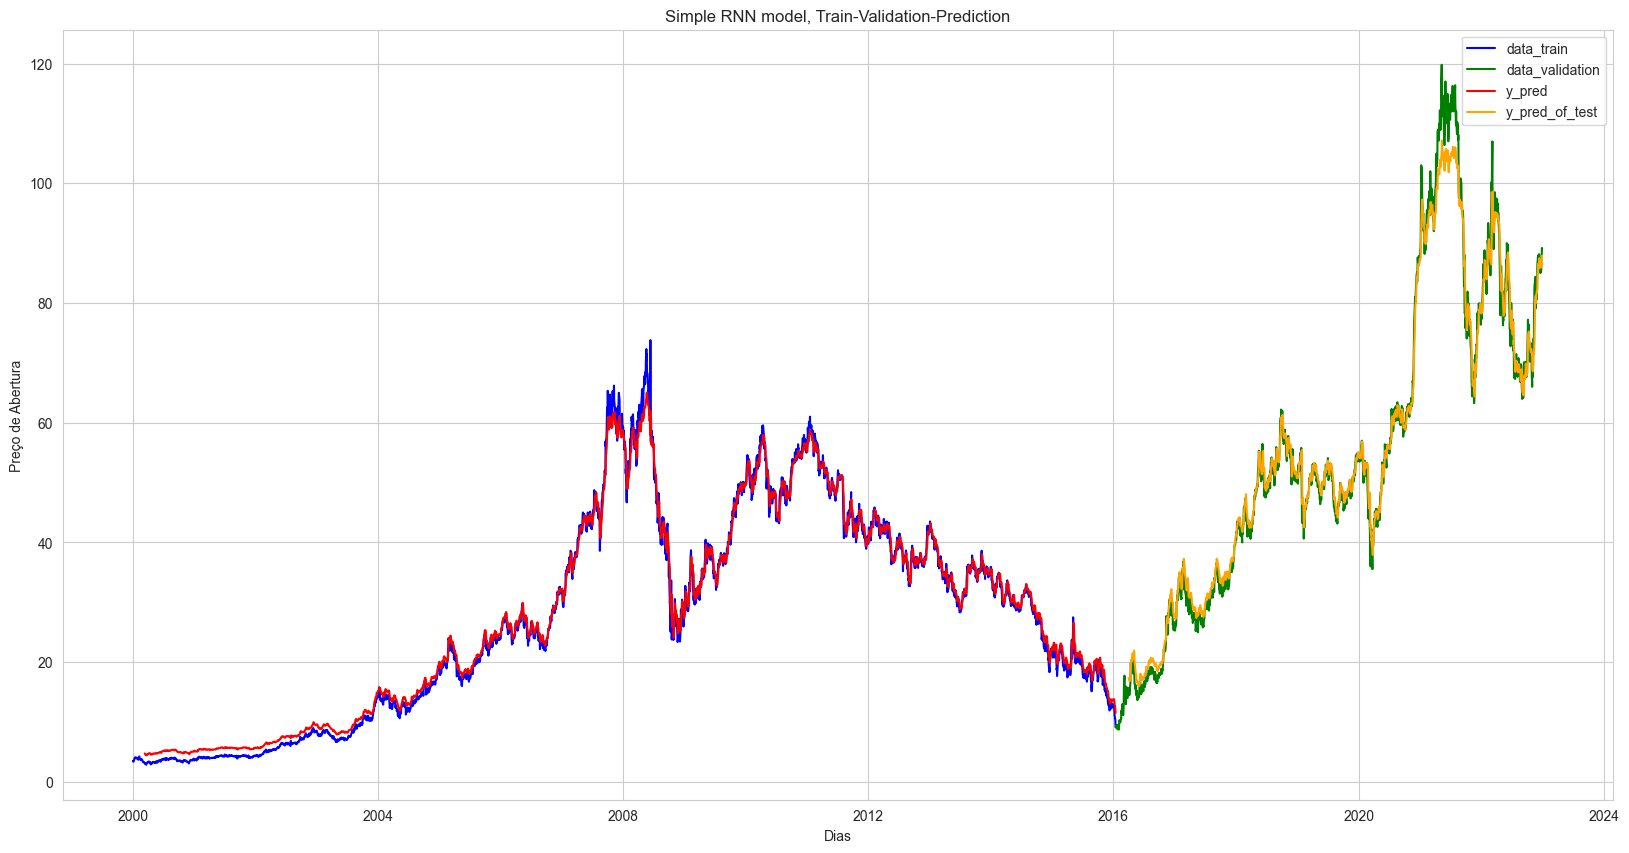

In [106]:
# Visualisation
plt.subplots(figsize =(20,10))
plt.plot(data_train.Date, data_train.Abertura, label = "data_train", color = "b")
plt.plot(data_validation.Date, data_validation.Abertura, label = "data_validation", color = "g")
plt.plot(data_train.Date.iloc[50:], y_pred, label = "y_pred", color = "r")
plt.plot(data_validation.Date.iloc[50:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Dias")
plt.ylabel("Preço de Abertura")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

## 5. Creating LSTM Model

In [107]:
y_train = scaler.fit_transform(y_train)

# initializing the LSTM
model_lstm = Sequential()

# adding LSTM layers 
model_lstm.add(LSTM(64,return_sequences=True,input_shape = (x_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(LSTM(64, return_sequences= False))
# final layers
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae', 'accuracy', 'mape'])
# fitting the LSTM
history2 = model_lstm.fit(x_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
125/125 [==============================] - 11s 38ms/step - loss: 0.0061 - mae: 0.0376 - accuracy: 5.0063e-04 - mape: 1901.9733
Epoch 2/50
125/125 [==============================] - 5s 36ms/step - loss: 5.4527e-04 - mae: 0.0157 - accuracy: 5.0063e-04 - mape: 1924.1687
Epoch 3/50
125/125 [==============================] - 4s 30ms/step - loss: 5.5813e-04 - mae: 0.0163 - accuracy: 5.0063e-04 - mape: 67.3322
Epoch 4/50
125/125 [==============================] - 5s 36ms/step - loss: 5.0808e-04 - mae: 0.0154 - accuracy: 5.0063e-04 - mape: 294.2365
Epoch 5/50
125/125 [==============================] - 4s 36ms/step - loss: 4.3160e-04 - mae: 0.0141 - accuracy: 5.0063e-04 - mape: 1459.0032
Epoch 6/50
125/125 [==============================] - 4s 35ms/step - loss: 3.9620e-04 - mae: 0.0135 - accuracy: 5.0063e-04 - mape: 596.9521
Epoch 7/50
125/125 [==============================] - 4s 35ms/step - loss: 3.8743e-04 - mae: 0.0133 - accuracy: 5.0063e-04 - mape: 697.1135
Epoch 8/50
125/125 [=

53/53 [==============================] - 1s 11ms/step


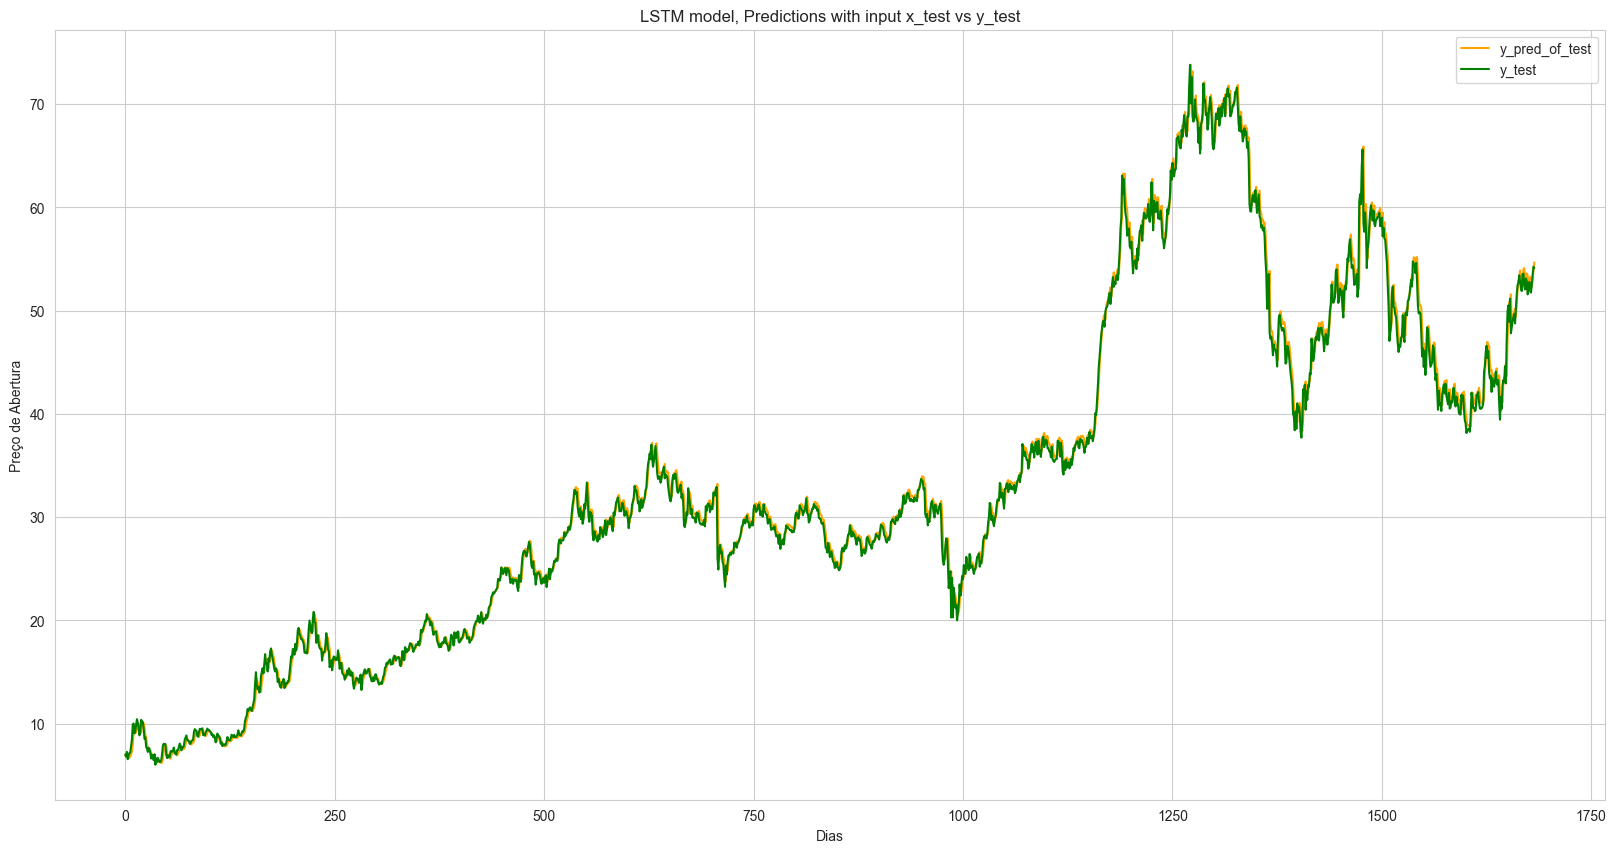

In [108]:
plt.subplots(figsize =(20,10))
plt.plot(scaler.inverse_transform(model_lstm.predict(x_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Dias")
plt.ylabel("Preço de Abertura")
plt.title("LSTM model, Predictions with input x_test vs y_test")
plt.legend()
plt.show()

## 6. Creating CNN Model

In [114]:
# initializing the CNN
model_cnn = Sequential()

# adding CNN layers and dropout regulatization
model_cnn.add(Conv1D(64, kernel_size = 3, activation ='relu', input_shape = (x_train.shape[1],1)))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(128, kernel_size = 3, activation = 'relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(64, kernel_size = 3, activation = 'relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())

# final layers
model_cnn.add(Dense(1))
model_cnn.compile(optimizer='adam', loss='mse', metrics=['mae', 'accuracy', 'mape'])

# fitting the CNN
history3 = model_cnn.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
125/125 [==============================] - 2s 6ms/step - loss: 0.0074 - mae: 0.0485 - accuracy: 5.0063e-04 - mape: 5994.2939
Epoch 2/50
125/125 [==============================] - 1s 6ms/step - loss: 0.0017 - mae: 0.0281 - accuracy: 5.0063e-04 - mape: 4808.9775
Epoch 3/50
125/125 [==============================] - 1s 7ms/step - loss: 0.0015 - mae: 0.0263 - accuracy: 5.0063e-04 - mape: 5070.3481
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0012 - mae: 0.0241 - accuracy: 5.0063e-04 - mape: 3359.4414
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0012 - mae: 0.0238 - accuracy: 5.0063e-04 - mape: 5367.1743
Epoch 6/50
125/125 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0228 - accuracy: 5.0063e-04 - mape: 3677.2102
Epoch 7/50
125/125 [==============================] - 1s 5ms/step - loss: 0.0011 - mae: 0.0227 - accuracy: 5.0063e-04 - mape: 3625.4688
Epoch 8/50
125/125 [============================

53/53 [==============================] - 0s 2ms/step


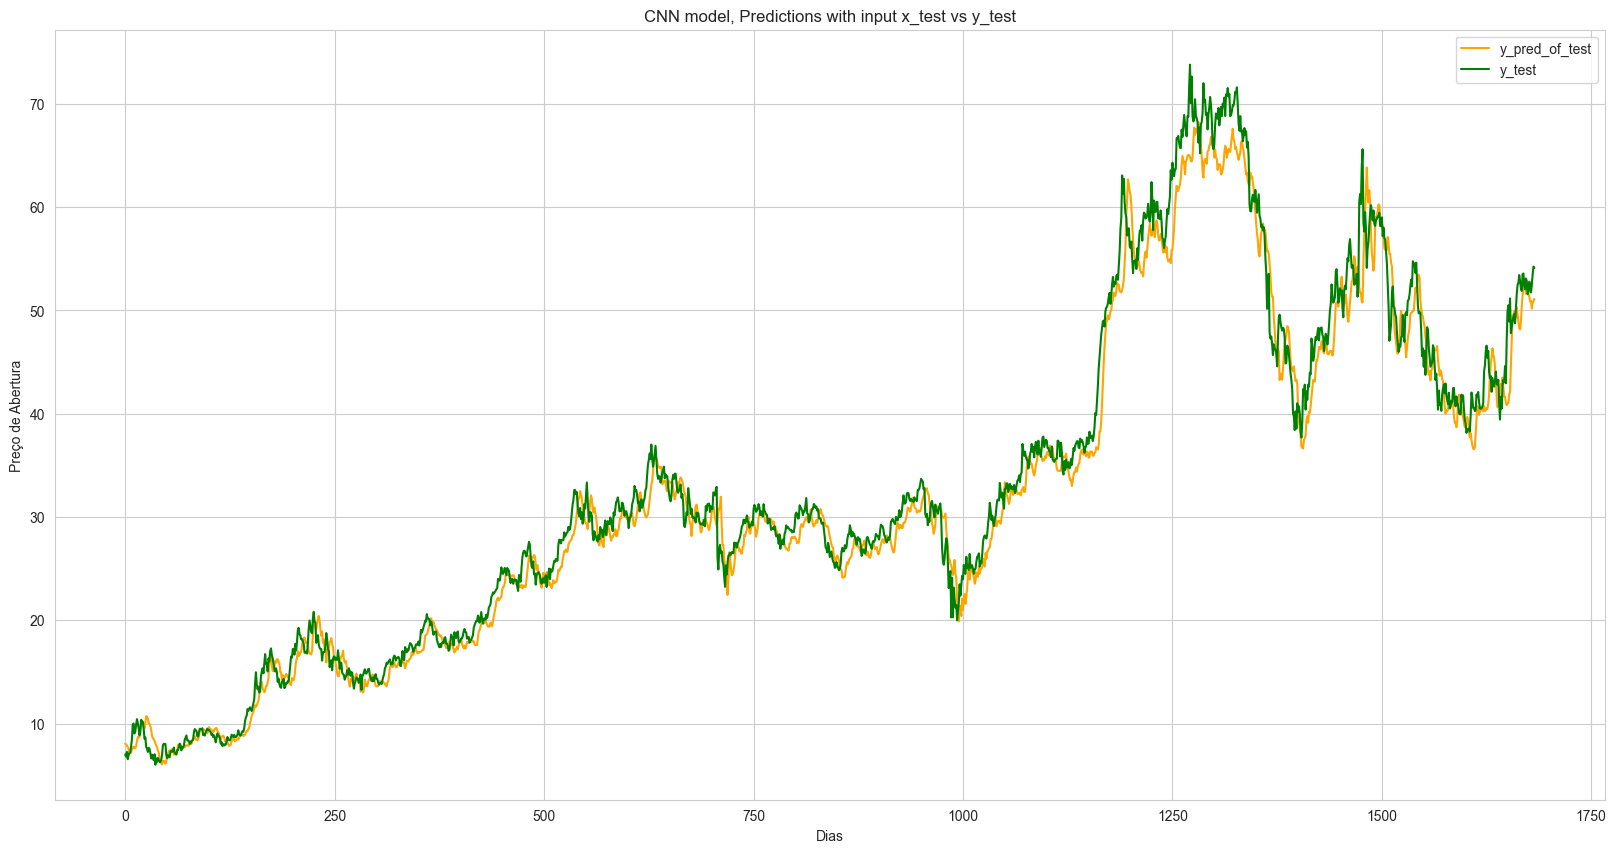

In [115]:
plt.subplots(figsize =(20,10))
plt.plot(scaler.inverse_transform(model_cnn.predict(x_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Dias")
plt.ylabel("Preço de Abertura")
plt.title("CNN model, Predictions with input x_test vs y_test")
plt.legend()
plt.show()

## 7. Evaluation of models

In [116]:
print(model_cnn.summary())
print(model_rnn.summary())
print(model_lstm.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 48, 64)            256       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 22, 128)           24704     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 11, 128)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 9, 64)             24640     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 4, 64)           

In [121]:
y_pred_rnn = model_rnn.predict(x_train)  
y_pred_rnn = scaler.inverse_transform(y_pred_rnn) 

y_pred_lstm = model_lstm.predict(x_train)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

y_pred_cnn = model_cnn.predict(x_train)  
y_pred_cnn = scaler.inverse_transform(y_pred_cnn) 

y_train = scaler.inverse_transform(y_train) 
y_pred_cnn.shape, y_train.shape, y_pred_lstm.shape, y_pred_rnn.shape

125/125 [==============================] - 0s 2ms/step


((3995, 1), (3995, 1), (3995, 1), (3995, 1))

In [134]:
rmse_rnn = np.sqrt(np.mean(((y_pred_rnn - y_train) ** 2)))
rmse_lstm = np.sqrt(np.mean(((y_pred_lstm - y_train) ** 2)))
rmse_cnn = np.sqrt(np.mean(((y_pred_cnn - y_train) ** 2)))

print('RNN RMSE:', round(rmse_rnn, 2))
print('LSTM RMSE:', round(rmse_lstm,2))
print('CNN RMSE:', round(rmse_cnn, 2))

RNN RMSE: 2261.23
LSTM RMSE: 2260.93
CNN RMSE: 2262.05


In [128]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [141]:
mape_rnn = mean_absolute_percentage_error(y_test, y_pred_rnn)
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_lstm)
mape_cnn = mean_absolute_percentage_error(y_test, y_pred_cnn)

print("RNN MAPE:", round(mape_rnn, 2))
print("LSTM MAPE:", round(mape_lstm, 2))
print("CNN MAPE:", round(mape_cnn, 2))

RNN MAPE: 3102.75
LSTM MAPE: 2596.94
CNN MAPE: 2581.78


In [139]:
from sklearn.metrics import mean_absolute_error as mae

mae_rnn = mae(y_train, y_pred_rnn)
mae_cnn = mae(y_train, y_pred_cnn)
mae_lstm = mae(y_train, y_pred_lstm)

print("RNN MAE:", round(mae_rnn, 2))
print("LSTM MAE:", round(mae_lstm, 2))
print("CNN MAE:", round(mae_cnn, 2))

RNN MAE: 1913.37
LSTM MAE: 1913.63
CNN MAE: 1914.46


In [140]:
from sklearn.metrics import mean_squared_error as mse

mse_rnn = mse(y_train, y_pred_rnn)
mse_lstm = mse(y_train, y_pred_lstm)
mse_cnn = mse(y_train, y_pred_cnn)

print("RNN MSE:", round(mse_rnn, 2))
print("LSTM MSE:", round(mse_lstm, 2))
print("CNN MSE:", round(mse_cnn, 2))

RNN MSE: 5113154.47
LSTM MSE: 5111826.27
CNN MSE: 5116856.41


In [158]:
models_metrics = [{'RNN': round(mape_rnn,2), 'LSTM': round(mape_lstm,2), 'CNN': round(mape_cnn,2)},
                 {'RNN': round(mae_rnn,2), 'LSTM': round(mae_lstm,2), 'CNN': round(mae_cnn,2)},
                 {'RNN': round(mse_rnn,2), 'LSTM': round(mse_lstm,2), 'CNN': round(mse_cnn,2)}]

models_metrics = pd.DataFrame(models_metrics)
models_metrics

,RNN,LSTM,CNN
0,3102.75,2596.94,2581.78
1,1913.37,1913.63,1914.46
2,5113154.47,5111826.27,5116856.41


In [159]:
models_metrics = models_metrics.rename(index={0: 'MAPE', 1: 'MAE', 2: 'MSE'})
print(models_metrics)

             RNN        LSTM         CNN
MAPE     3102.75     2596.94     2581.78
MAE      1913.37     1913.63     1914.46
MSE   5113154.47  5111826.27  5116856.41


In [161]:
models_metrics

,RNN,LSTM,CNN
MAPE,3102.75,2596.94,2581.78
MAE,1913.37,1913.63,1914.46
MSE,5113154.47,5111826.27,5116856.41
